In [11]:
# Import libraries
import os
import pprint
import numpy as np
import wandb
import torch
import torch.nn as nn
import time
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import *
from models import FCN
# Ensure reproducibility
torch.backends.cudnn.deterministic = True
seed_no = 108
np.random.seed(hash("improves reproducibility") % seed_no)
torch.manual_seed(hash("by removing stochasticity") % seed_no)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % seed_no)
# Device configuration
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
class CAE(nn.Module):
    def __init__(self, dim, h_dim):
        super(CAE, self).__init__()
        self.dim = dim
        self.h_dim = h_dim

        # Encoder
        self.encoder = nn.Sequential(
                nn.Conv2d(1, self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(self.dim),

                nn.Conv2d(self.dim, 2 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(2 * self.dim),

                nn.Conv2d(2 * self.dim, 4 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(4 * self.dim),

                nn.Conv2d(4 * self.dim, 8 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(8 * self.dim)
            )
    
        # Bottleneck
        self.bottleneck = nn.Sequential(
                nn.Linear(self.dim * 32, self.h_dim),
                nn.LeakyReLU(0.25),
                nn.BatchNorm1d(self.h_dim),

                nn.Linear(self.h_dim, self.dim * 32),
                nn.LeakyReLU(0.25),
                nn.BatchNorm1d(self.dim * 32)

            )

    
        # Decoder
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(8 * self.dim, 4 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(4 * self.dim),

                nn.ConvTranspose2d(4 * self.dim, 2 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(2 * self.dim),

                nn.ConvTranspose2d(2 * self.dim, self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(self.dim),

                nn.ConvTranspose2d(self.dim, 1, 4, 2, 1),
                nn.LeakyReLU(0.25)
            )
    
    def forward(self, x):
        x = self.encoder(x)
        x = torch.reshape(x, (-1, self.dim * 32))
        x = self.bottleneck(x)
        x = torch.reshape(x, (-1, self.dim * 8, 2, 2))
        output = self.decoder(x)
        return output


In [13]:
# Loading the data
permeability = np.load("hw6_data/permeability.npy")
pressure = np.load("hw6_data/pressure.npy")

# Normalize the data between -1 and 1
permeability = ((permeability - permeability.min())/(permeability.max()-permeability.min()))*2 - 1.
pressure = ((pressure - pressure.min())/(pressure.max()-pressure.min()))*2 - 1.

# Hyperparameters
num_epochs = 150
log_freq = int(0.1 * num_epochs)
n_train = int(0.8 * permeability.shape[0])

# Data loader
train_permeability = torch.from_numpy(permeability[:n_train, :, :]).float().to(device)
train_pressure = torch.from_numpy(pressure[:n_train, :, :]).float().to(device)

val_permeability = torch.from_numpy(permeability[n_train:, :, :]).float().to(device)
val_pressure = torch.from_numpy(pressure[n_train:, :, :]).float().to(device)

train_dataset = torch.utils.data.TensorDataset(train_permeability, train_pressure)
test_dataset = torch.utils.data.TensorDataset(val_permeability, val_pressure)

In [14]:
#wandb hyperparameter dictionary
sweep_configuration = {
    "method": "grid",
    "name": "grid_search",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": 
    {
        "dim": {"values": [16.0]},
        "h_dim": {"values": [64.0]},
        "lr": {"values": [0.001]},
        "reg_param": {"values": [0.0]},
        "batch_size": {"values": [1024]}
     }
}
pprint.pprint(sweep_configuration)
project_name = "cme216_hw6"
group_name = "grid_search_hw6"
sweep_id = wandb.sweep(sweep_configuration, project=project_name)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'name': 'grid_search',
 'parameters': {'batch_size': {'values': [1024]},
                'dim': {'values': [16.0]},
                'h_dim': {'values': [64.0]},
                'lr': {'values': [0.001]},
                'reg_param': {'values': [0.0]}}}
Create sweep with ID: z7j0orun
Sweep URL: https://wandb.ai/abroze/cme216_hw6/sweeps/z7j0orun


wandb: Agent Starting Run: d48h6tns with config:
wandb: 	batch_size: 1024
wandb: 	dim: 16
wandb: 	h_dim: 64
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run d48h6tns errored: IndexError('index 4 is out of bounds for axis 0 with size 4')
wandb: ERROR Run d48h6tns errored: IndexError('index 4 is out of bounds for axis 0 with size 4')
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Total time taken: 47.21948218345642


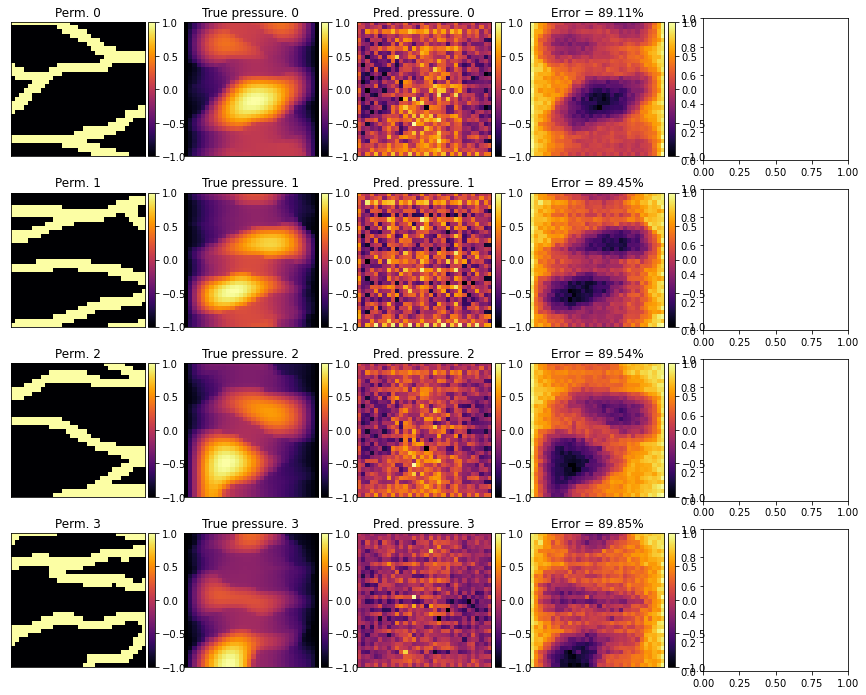

In [15]:
t1 = time.time()
# ==============================================================================
# Training
# ==============================================================================
# Train the model
def train(config=None):
    # Initialize the new wandb run
    wandb.init(config=config, project=project_name, group=group_name) 
    config = wandb.config
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=config.batch_size,
                                                shuffle=True)
    total_step = len(train_loader)
    loss_list = []


    # Model, Loss, and Optimizer
    model = CAE(config.dim, config.h_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.reg_param)
    for epoch in range(num_epochs):
        for i, (train_x, train_y) in enumerate(train_loader):
            # Run the forward pass
            model.train()
            output = model(train_x.unsqueeze(1))
            loss = criterion(output, train_y.unsqueeze(1))
            loss_list.append(loss.item())
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % log_freq == 0:
            # Calculate the validation loss
            model.eval()
            with torch.no_grad():
                val_pressure_pred = model(val_permeability.unsqueeze(1))                    
                val_loss = criterion(val_pressure_pred, val_pressure.unsqueeze(1))
            
            plot_perm_and_temp(val_permeability.detach().cpu().numpy().squeeze(), 
                                val_pressure.detach().cpu().numpy().squeeze(), 
                                val_pressure_pred.detach().cpu().numpy().squeeze(), epoch)
            diff_ = (val_pressure_pred - val_pressure.unsqueeze(1)).detach().cpu().numpy().squeeze()
            diff_vec = np.reshape(diff_, (diff_.shape[0], -1))
            val_l2_pt_error = np.mean(np.linalg.norm(diff_vec, axis=1) / np.linalg.norm(np.reshape(val_pressure.detach().cpu().numpy(), (val_pressure.shape[0], -1)), axis=1), axis=0) * 100
            
            wandb.log({"val_loss": val_loss.item(), "train_loss": loss.item(), "val_rel_error_pt": val_l2_pt_error, "epoch": epoch})
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], \
                    Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, \
                    Val. error (in %) = {val_l2_pt_error:.2f}%")

    # Save the model checkpoint (optional)
    save_path = os.path.join(wandb.run.dir, "model.ckpt")
    torch.save(model.state_dict(), save_path)

wandb.agent(sweep_id, train)
t2 = time.time()
print(f"Total time taken: {t2-t1}")
wandb.finish()